In [ ]:
# Import necessary libraries
from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

In [ ]:
# Define the neural network architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Define convolutional layers
        self.conv1 = nn.Conv2d(1, 8, 3, 1)
        self.conv2 = nn.Conv2d(8, 16, 3, 1)
        # Define dropout layers
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        # Define fully connected layers
        self.fc1 = nn.Linear(2304, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        # Forward pass through the network with different activation functions
        x = self.conv1(x)
        # x = F.relu(x)
        # x = F.rrelu(x)
        # x = F.relu6(x)
        # x = F.leaky_relu(x)
        x = F.hardswish(x)

        x = self.conv2(x)
        # x = F.relu(x)
        # x = F.rrelu(x)
        # x = F.relu6(x)
        # x = F.leaky_relu(x)
        x = F.hardswish(x)

        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)

        # x = F.relu(x)
        # x = F.rrelu(x)
        # x = F.relu6(x)
        # x = F.leaky_relu(x)
        x = F.hardswish(x)

        x = self.dropout2(x)
        x = self.fc2(x)
        return x

In [ ]:
# Define the training function
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    plt.figure()
    pic = None
    for batch_idx, (data, target) in enumerate(train_loader):
        if batch_idx in (1,2,3,4,5):
            if batch_idx == 1:
                pic = data[0,0,:,:]
            else:
                pic = torch.cat((pic,data[0,0,:,:]),dim=1)
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        # Backpropagation and optimization
        loss.backward()
        # Optimize the parameters according to the calculated gradients
        optimizer.step()
        # Print training progress
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            if args.dry_run:
                break
    # Display sample images
    plt.imshow(pic.cpu(), cmap='gray')
    plt.show()

In [ ]:
# Define the testing function
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item()  # Sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # Get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
# Define configuration parameters
class config:
  batch_size = 64
  test_batch_size = 1000
  epochs = 14
  lr = 1.0
  gamma = 0.7
  no_cuda = False
  dry_run = False
  seed = 1
  log_interval = 10
  save_model = True

In [ ]:
# Define the main function for training and testing
def main():
    args =config()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    torch.manual_seed(args.seed)

    device = torch.device("cuda" if use_cuda else "cpu")

    # Batch_size is a crucial hyper-parameter
    train_kwargs = {'batch_size': args.batch_size}
    test_kwargs = {'batch_size': args.test_batch_size}
    if use_cuda:
        # Adjust num worker and pin memory according to your computer performance
        cuda_kwargs = {'num_workers': 1,
                       'pin_memory': True,
                       'shuffle': True}
        train_kwargs.update(cuda_kwargs)
        test_kwargs.update(cuda_kwargs)

    # Normalize the input (black and white image)
    transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
        ])

    # Make train dataset split
    dataset1 = datasets.MNIST('./data', train=True, download=True,
                       transform=transform)
    # Make test dataset split
    dataset2 = datasets.MNIST('./data', train=False,
                       transform=transform)

    # Convert the dataset to dataloader, including train_kwargs and test_kwargs
    train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
    test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

    # Put the model on the GPU or CPU
    model = Net().to(device)

    # Create optimizer
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)

    # Create a schedule for the optimizer
    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)

    # Begin training and testing
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(model, device, test_loader)
        scheduler.step()

    # Save the model
    if args.save_model:
        torch.save(model.state_dict(), "mnist_cnn.pt")


In [ ]:
    # This process customize the training settings (batch size, learning rate)[optional step]

    # parser = argparse.ArgumentParser(description='PyTorch MNIST Example')
    # parser.add_argument('--batch-size', type=int, default=64, metavar='N',
    #                     help='input batch size for training (default: 64)')
    # parser.add_argument('--test-batch-size', type=int, default=1000, metavar='N',
    #                     help='input batch size for testing (default: 1000)')
    # parser.add_argument('--epochs', type=int, default=14, metavar='N',
    #                     help='number of epochs to train (default: 14)')
    # parser.add_argument('--lr', type=float, default=1.0, metavar='LR',
    #                     help='learning rate (default: 1.0)')
    # parser.add_argument('--gamma', type=float, default=0.7, metavar='M',
    #                     help='Learning rate step gamma (default: 0.7)')
    # parser.add_argument('--no-cuda', action='store_true', default=False,
    #                     help='disables CUDA training')
    # parser.add_argument('--dry-run', action='store_true', default=False,
    #                     help='quickly check a single pass')
    # parser.add_argument('--seed', type=int, default=1, metavar='S',
    #                     help='random seed (default: 1)')
    # parser.add_argument('--log-interval', type=int, default=10, metavar='N',
    #                     help='how many batches to wait before logging training status')
    # parser.add_argument('--save-model', action='store_true', default=False,
    #                     help='For Saving the current Model')
    # args = parser.parse_args()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301388
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.658079
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.294760
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.977675
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.660311
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.482765
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.625867
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.292756
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.446017
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.404280
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.269533
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.418496
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.326269
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.339768
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.322833
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.484935
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.253000
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.342398
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.220437
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.625057
Train Epoch: 1 [12800/60000 (

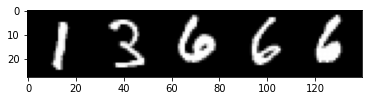


Test set: Average loss: 0.0624, Accuracy: 9798/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.095599
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.072881
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.044114
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.113923
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.235609
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.178443
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.044178
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.103626
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.296133
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.284813
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.108890
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.095535
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.074074
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.105526
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.185847
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.251344
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.287888
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.025412
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.204465
Train Epoch: 2 [12

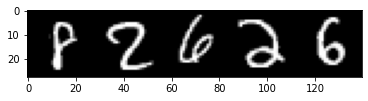


Test set: Average loss: 0.0477, Accuracy: 9857/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.050460
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.071413
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.132951
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.028606
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.117055
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.092512
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.142107
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.170554
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.208553
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.081882
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.036800
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.097204
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.204882
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.146359
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.250222
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.087905
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.029218
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.039101
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.051741
Train Epoch: 3 [12

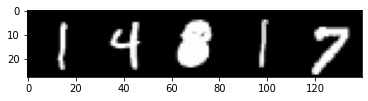


Test set: Average loss: 0.0496, Accuracy: 9860/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.063405
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.107037
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.018093
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.041717
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.016303
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.081858
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.040981
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.099547
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.111782
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.085777
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.121718
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.161216
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.078049
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.093655
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.050909
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.024884
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.032350
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.056958
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.045650
Train Epoch: 4 [12

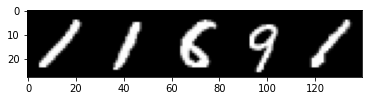


Test set: Average loss: 0.0426, Accuracy: 9864/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.034807
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.038802
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.106486
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.089456
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.031984
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.077325
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.020571
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.084640
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.152359
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.039856
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.094096
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.200251
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.029232
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.095069
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.150816
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.109850
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.013276
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.101952
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.090246
Train Epoch: 5 [12

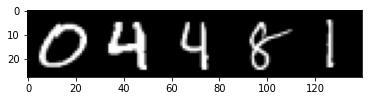


Test set: Average loss: 0.0437, Accuracy: 9871/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.073271
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.068526
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.023009
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.107657
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.081007
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.019884
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.061082
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.031408
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.024358
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.064046
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.018749
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.151591
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.153857
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.180928
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.055326
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.054113
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.029216
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.075324
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.081816
Train Epoch: 6 [12

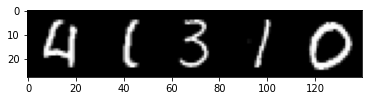


Test set: Average loss: 0.0392, Accuracy: 9877/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.359839
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.150749
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.081077
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.135223
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.080042
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.050055
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.008017
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.017608
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.120582
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.147796
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.126624
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.151968
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.058009
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.165212
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.061514
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.025631
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.038364
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.323383
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.032797
Train Epoch: 7 [12

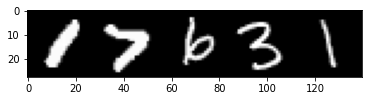


Test set: Average loss: 0.0380, Accuracy: 9876/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.021456
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.157438
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.131073
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.187295
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.087522
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.008494
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.139479
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.029482
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.142843
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.045166
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.054211
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.042310
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.130411
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.140236
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.076032
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.015880
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.132065
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.056703
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.063436
Train Epoch: 8 [12

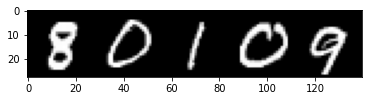


Test set: Average loss: 0.0381, Accuracy: 9876/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.137077
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.061938
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.064278
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.041425
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.035679
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.057222
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.108118
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.044125
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.123703
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.067714
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.141428
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.024417
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.098675
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.164647
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.029443
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.151084
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.065107
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.044533
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.067933
Train Epoch: 9 [12

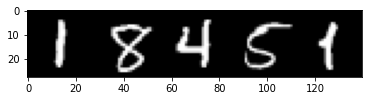


Test set: Average loss: 0.0382, Accuracy: 9882/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.208577
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.043357
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.036137
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.035804
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.009756
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.095454
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.012052
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.054308
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.037550
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.105443
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.061328
Train Epoch: 10 [7040/60000 (12%)]	Loss: 0.176089
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.028574
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.019368
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.110951
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.043654
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.163833
Train Epoch: 10 [10880/60000 (18%)]	Loss: 0.123050
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.179739

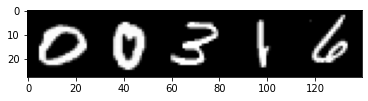


Test set: Average loss: 0.0367, Accuracy: 9876/10000 (99%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.080326
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.060259
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.021976
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.015619
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.017088
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.037639
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.211056
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.054796
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.107959
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.036926
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.015644
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.028841
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.067022
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.051344
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.018175
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.144199
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.030814
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.040142
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.042502

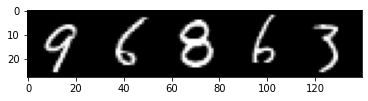


Test set: Average loss: 0.0365, Accuracy: 9882/10000 (99%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.130167
Train Epoch: 12 [640/60000 (1%)]	Loss: 0.128529
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.061901
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.087571
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.021846
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.098123
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.073613
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.079953
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.034702
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.036060
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.021876
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.019684
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.024711
Train Epoch: 12 [8320/60000 (14%)]	Loss: 0.287964
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.055754
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.119107
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.019909
Train Epoch: 12 [10880/60000 (18%)]	Loss: 0.075958
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.043985

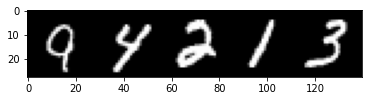


Test set: Average loss: 0.0363, Accuracy: 9880/10000 (99%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.077591
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.090154
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.060573
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.011375
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.054057
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.305411
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.078375
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.101767
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.018278
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.046482
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.013767
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.094220
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.092978
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.073628
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.130846
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.160240
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.057511
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.028477
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.031143

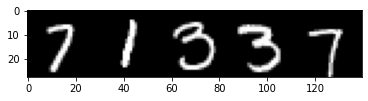


Test set: Average loss: 0.0361, Accuracy: 9882/10000 (99%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.016351
Train Epoch: 14 [640/60000 (1%)]	Loss: 0.078601
Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.032530
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.032937
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.018122
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.022026
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.048425
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.153774
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.131081
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.035389
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.037642
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.191860
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.043734
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.021483
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.130472
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.078614
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.129015
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.022004
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.047171

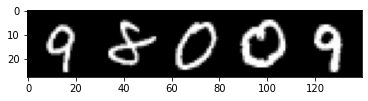


Test set: Average loss: 0.0363, Accuracy: 9883/10000 (99%)



In [ ]:
# Run the main function with different activation functions
# Results using relu()
if __name__ == '__main__':
     main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.306995
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.485736
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.863550
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.698956
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.483080
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.432397
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.478840
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.192929
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.261925
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.306022
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.180537
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.292789
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.296125
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.289389
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.264216
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.366854
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.227341
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.222454
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.114591
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.596988
Train Epoch: 1 [12800/60000 (

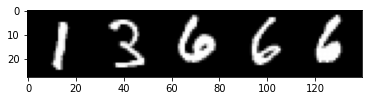


Test set: Average loss: 0.0645, Accuracy: 9782/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.108977
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.068937
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.019367
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.095120
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.217495
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.147655
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.072751
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.094872
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.250354
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.151838
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.066333
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.103637
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.073674
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.066258
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.193373
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.348752
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.119195
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.055127
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.204406
Train Epoch: 2 [12

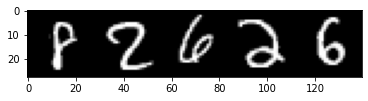


Test set: Average loss: 0.0499, Accuracy: 9838/10000 (98%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.017420
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.044485
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.113249
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.021326
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.113820
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.106296
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.066790
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.121606
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.120388
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.158594
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.067089
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.059533
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.101720
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.081054
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.186440
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.035899
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.086116
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.032402
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.003892
Train Epoch: 3 [12

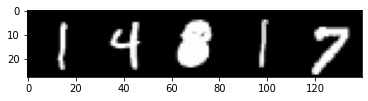


Test set: Average loss: 0.0556, Accuracy: 9828/10000 (98%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.050549
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.079206
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.018964
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.022743
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.009714
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.071195
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.028853
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.254105
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.113615
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.118906
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.189025
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.155565
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.006873
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.241771
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.044216
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.004565
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.007985
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.054732
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.037056
Train Epoch: 4 [12

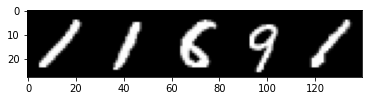


Test set: Average loss: 0.0425, Accuracy: 9861/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.010659
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.007427
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.016971
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.124995
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.036465
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.070152
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.016859
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.112825
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.113190
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.056228
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.055977
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.146600
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.027311
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.094579
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.167893
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.040683
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.023925
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.030936
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.060995
Train Epoch: 5 [12

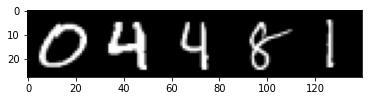


Test set: Average loss: 0.0440, Accuracy: 9863/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.126498
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.017769
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.023440
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.175751
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.041072
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.009903
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.165466
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.009824
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.025079
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.084939
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.026907
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.120280
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.038403
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.182368
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.025459
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.060327
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.047750
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.072130
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.040763
Train Epoch: 6 [12

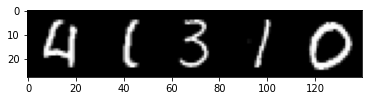


Test set: Average loss: 0.0396, Accuracy: 9871/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.295012
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.100271
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.050641
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.089633
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.094864
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.014382
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.005315
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.008787
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.015067
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.184989
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.023763
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.241332
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.050857
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.098227
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.004020
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.033870
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.023357
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.260963
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.012049
Train Epoch: 7 [12

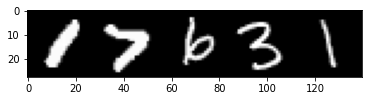


Test set: Average loss: 0.0383, Accuracy: 9876/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.006425
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.116354
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.087597
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.167580
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.031691
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.035829
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.098743
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.007522
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.025131
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.043397
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.041181
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.056631
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.106019
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.142712
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.138688
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.008663
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.118918
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.065265
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.038449
Train Epoch: 8 [12

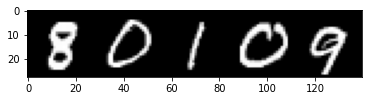


Test set: Average loss: 0.0389, Accuracy: 9874/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.157067
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.052104
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.089303
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.061601
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.025092
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.067454
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.110529
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.020618
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.052420
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.015025
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.097939
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.030257
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.025728
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.090441
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.014447
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.199558
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.006185
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.042227
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.049421
Train Epoch: 9 [12

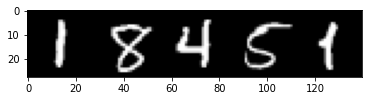


Test set: Average loss: 0.0384, Accuracy: 9881/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.167758
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.012892
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.012320
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.046662
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.011875
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.099709
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.021260
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.011236
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.042742
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.069449
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.057336
Train Epoch: 10 [7040/60000 (12%)]	Loss: 0.189780
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.012644
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.020361
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.105009
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.016827
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.060187
Train Epoch: 10 [10880/60000 (18%)]	Loss: 0.056224
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.101076

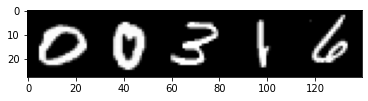


Test set: Average loss: 0.0373, Accuracy: 9881/10000 (99%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.107146
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.067455
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.033721
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.071311
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.030805
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.033304
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.140297
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.040186
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.065074
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.031013
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.027538
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.022969
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.078200
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.016831
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.043120
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.079498
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.010333
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.026397
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.021665

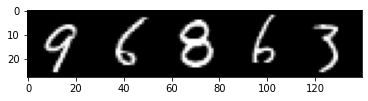


Test set: Average loss: 0.0371, Accuracy: 9880/10000 (99%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.096122
Train Epoch: 12 [640/60000 (1%)]	Loss: 0.048508
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.027749
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.053307
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.028074
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.117091
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.041819
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.035728
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.013250
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.089968
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.008522
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.019046
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.007528
Train Epoch: 12 [8320/60000 (14%)]	Loss: 0.274407
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.030827
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.043328
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.012410
Train Epoch: 12 [10880/60000 (18%)]	Loss: 0.085065
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.031070

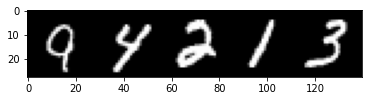


Test set: Average loss: 0.0369, Accuracy: 9884/10000 (99%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.055864
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.058334
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.029886
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.016060
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.079238
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.208575
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.018634
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.052205
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.024257
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.017500
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.008237
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.063262
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.186875
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.057240
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.063813
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.029775
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.061436
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.025495
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.012422

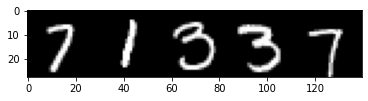


Test set: Average loss: 0.0371, Accuracy: 9881/10000 (99%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.030813
Train Epoch: 14 [640/60000 (1%)]	Loss: 0.021746
Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.017902
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.024666
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.002293
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.013577
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.114679
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.077777
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.027671
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.054918
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.014043
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.105380
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.054648
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.046633
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.111793
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.027786
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.165277
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.011289
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.041208

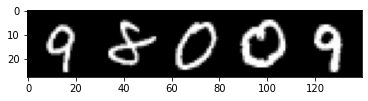


Test set: Average loss: 0.0371, Accuracy: 9881/10000 (99%)



In [ ]:
# Results using rrelu()
if __name__ == '__main__':
  main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301388
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.658136
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.306975
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.945694
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.656043
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.503881
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.603525
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.272263
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.501469
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.410379
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.243626
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.397812
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.334766
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.364958
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.319265
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.546555
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.242304
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.280324
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.198896
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.602004
Train Epoch: 1 [12800/60000 (

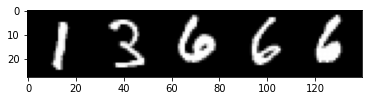


Test set: Average loss: 0.0682, Accuracy: 9771/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.091072
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.077651
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.027939
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.107506
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.223545
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.176867
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.041353
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.109057
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.316983
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.239929
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.061393
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.100551
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.075055
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.120576
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.202775
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.245827
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.252787
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.028879
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.206349
Train Epoch: 2 [12

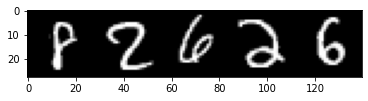


Test set: Average loss: 0.0459, Accuracy: 9857/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.042482
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.068289
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.117305
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.040685
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.175906
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.073045
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.117421
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.139569
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.205110
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.087781
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.045702
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.087186
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.236302
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.194643
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.291816
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.094420
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.031914
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.039823
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.020418
Train Epoch: 3 [12

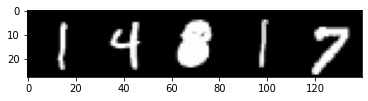


Test set: Average loss: 0.0476, Accuracy: 9866/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.033726
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.149460
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.024529
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.087712
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.024062
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.097777
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.036886
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.099646
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.100422
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.096366
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.120303
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.165877
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.112555
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.117651
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.065611
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.023238
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.020375
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.061332
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.060415
Train Epoch: 4 [12

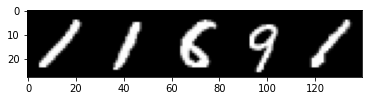


Test set: Average loss: 0.0437, Accuracy: 9868/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.028097
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.032389
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.094311
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.077203
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.031109
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.068243
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.020764
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.094343
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.134801
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.048158
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.083686
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.170247
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.042882
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.116203
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.180589
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.111094
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.014299
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.079942
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.074237
Train Epoch: 5 [12

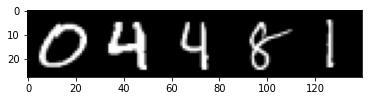


Test set: Average loss: 0.0417, Accuracy: 9873/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.036679
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.038750
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.024509
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.105901
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.103256
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.016666
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.077643
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.029461
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.023211
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.089554
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.031764
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.116079
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.150179
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.217498
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.045420
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.050963
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.037302
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.096012
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.086775
Train Epoch: 6 [12

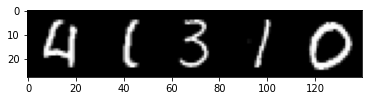


Test set: Average loss: 0.0383, Accuracy: 9873/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.392851
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.129653
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.063403
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.104406
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.095892
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.054784
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.011237
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.014279
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.096745
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.119123
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.068535
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.168146
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.048748
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.156934
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.028609
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.024769
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.025772
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.348161
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.046887
Train Epoch: 7 [12

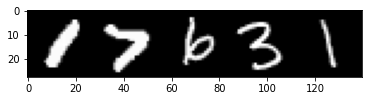


Test set: Average loss: 0.0372, Accuracy: 9881/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.027409
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.177674
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.114318
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.149759
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.070073
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.006042
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.109842
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.021226
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.145869
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.039099
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.060467
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.021029
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.139324
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.128975
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.104094
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.016381
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.132570
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.039822
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.062598
Train Epoch: 8 [12

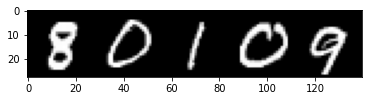


Test set: Average loss: 0.0370, Accuracy: 9886/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.123643
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.073223
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.063198
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.039366
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.025609
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.057142
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.078773
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.044077
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.111020
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.066047
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.100853
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.026410
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.081564
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.161441
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.027178
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.109123
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.057942
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.047977
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.065840
Train Epoch: 9 [12

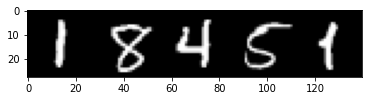


Test set: Average loss: 0.0372, Accuracy: 9890/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.208215
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.038817
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.018357
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.038322
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.008748
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.076577
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.008050
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.048165
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.046878
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.074768
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.077689
Train Epoch: 10 [7040/60000 (12%)]	Loss: 0.161178
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.023757
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.018106
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.133759
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.030818
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.195107
Train Epoch: 10 [10880/60000 (18%)]	Loss: 0.161639
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.173206

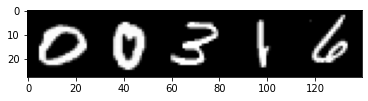


Test set: Average loss: 0.0362, Accuracy: 9884/10000 (99%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.080207
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.068901
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.031204
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.012165
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.011212
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.053108
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.194498
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.042442
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.140566
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.056817
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.018988
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.030120
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.084658
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.052755
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.029855
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.126470
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.033656
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.029304
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.070747

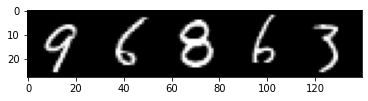


Test set: Average loss: 0.0359, Accuracy: 9890/10000 (99%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.156085
Train Epoch: 12 [640/60000 (1%)]	Loss: 0.124959
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.046151
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.095807
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.020267
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.099972
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.057233
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.045982
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.034602
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.029526
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.016957
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.028324
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.071710
Train Epoch: 12 [8320/60000 (14%)]	Loss: 0.303341
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.048948
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.087396
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.017709
Train Epoch: 12 [10880/60000 (18%)]	Loss: 0.091227
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.037579

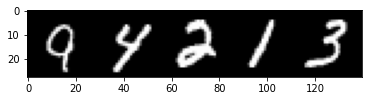


Test set: Average loss: 0.0354, Accuracy: 9893/10000 (99%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.096534
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.092292
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.058029
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.013460
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.074841
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.297542
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.086594
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.081335
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.021604
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.048609
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.007440
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.143495
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.086641
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.046448
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.116524
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.139493
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.067213
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.040505
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.032374

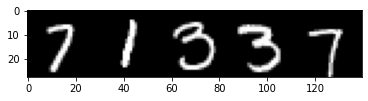


Test set: Average loss: 0.0356, Accuracy: 9890/10000 (99%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.027096
Train Epoch: 14 [640/60000 (1%)]	Loss: 0.072500
Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.025006
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.043630
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.016160
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.026579
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.032822
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.143117
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.133379
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.056171
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.063827
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.188307
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.047315
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.019103
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.144623
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.095562
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.140129
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.030568
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.061066

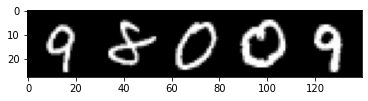


Test set: Average loss: 0.0355, Accuracy: 9894/10000 (99%)



In [ ]:
# Results using relu6()
if __name__ == '__main__':
     main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301657
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.624771
Train Epoch: 1 [1280/60000 (2%)]	Loss: 1.266288
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.971296
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.587690
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.479462
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.667139
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.276462
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.423724
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.402854
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.261326
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.444943
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.324978
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.323352
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.265324
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.536007
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.254220
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.245830
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.235546
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.609526
Train Epoch: 1 [12800/60000 (

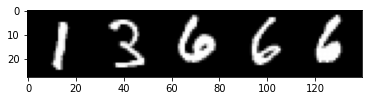


Test set: Average loss: 0.0728, Accuracy: 9767/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.108286
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.088281
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.014219
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.152839
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.208480
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.154034
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.024837
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.112335
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.288417
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.221892
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.111821
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.118513
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.131768
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.069396
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.181262
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.174089
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.185468
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.028136
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.206622
Train Epoch: 2 [12

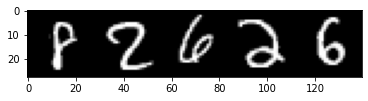


Test set: Average loss: 0.0477, Accuracy: 9851/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.028665
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.085272
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.090409
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.071365
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.156194
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.064109
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.076290
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.113957
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.151183
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.047379
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.033708
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.110216
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.251562
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.115575
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.227650
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.080438
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.040950
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.031821
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.026551
Train Epoch: 3 [12

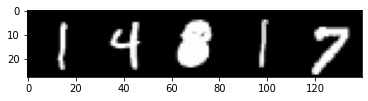


Test set: Average loss: 0.0528, Accuracy: 9855/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.120659
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.105361
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.023263
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.115981
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.078914
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.128281
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.055458
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.076658
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.103793
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.116342
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.188191
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.149177
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.117450
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.119493
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.066524
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.011097
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.017832
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.075311
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.057111
Train Epoch: 4 [12

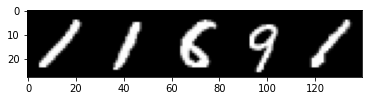


Test set: Average loss: 0.0459, Accuracy: 9868/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.016200
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.019073
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.071648
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.070283
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.023984
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.083587
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.042396
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.098285
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.100102
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.072430
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.117062
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.261015
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.027175
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.100358
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.145062
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.092262
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.026575
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.086408
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.058150
Train Epoch: 5 [12

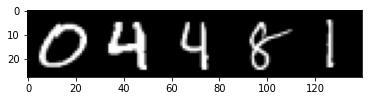


Test set: Average loss: 0.0439, Accuracy: 9870/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.091236
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.059358
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.018372
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.077734
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.085679
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.018062
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.097756
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.027647
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.030955
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.112545
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.028495
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.143525
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.172436
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.200337
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.055002
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.063414
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.051451
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.094873
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.055075
Train Epoch: 6 [12

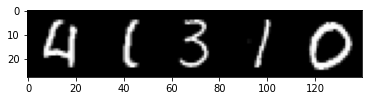


Test set: Average loss: 0.0408, Accuracy: 9874/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.380068
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.074798
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.096359
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.119302
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.086133
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.040274
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.011748
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.006675
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.083539
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.197870
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.132300
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.137616
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.056342
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.207915
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.087965
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.019482
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.027199
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.328430
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.053112
Train Epoch: 7 [12

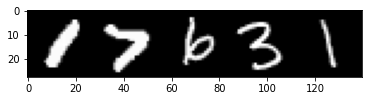


Test set: Average loss: 0.0392, Accuracy: 9877/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.026282
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.131294
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.147319
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.156457
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.071017
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.016660
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.117048
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.009113
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.120546
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.050826
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.060453
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.021310
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.159795
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.129058
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.087381
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.017009
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.106005
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.035185
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.040368
Train Epoch: 8 [12

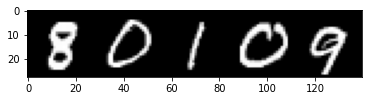


Test set: Average loss: 0.0393, Accuracy: 9879/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.103206
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.053289
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.106675
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.040949
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.029630
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.090982
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.081965
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.021365
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.106790
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.061644
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.114790
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.030999
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.077449
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.160115
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.057863
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.127296
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.034966
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.040117
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.070687
Train Epoch: 9 [12

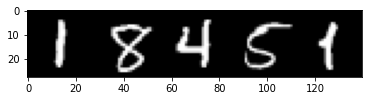


Test set: Average loss: 0.0395, Accuracy: 9881/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.186222
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.016722
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.027566
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.054462
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.006942
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.080602
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.019347
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.030907
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.038152
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.052397
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.082119
Train Epoch: 10 [7040/60000 (12%)]	Loss: 0.111799
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.038256
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.016991
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.076685
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.039365
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.188675
Train Epoch: 10 [10880/60000 (18%)]	Loss: 0.118320
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.155600

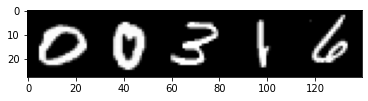


Test set: Average loss: 0.0383, Accuracy: 9879/10000 (99%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.064492
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.079885
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.032235
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.017148
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.011064
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.079523
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.215354
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.033259
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.215579
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.071792
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.028094
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.035636
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.102188
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.066772
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.030035
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.120873
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.023447
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.047217
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.022231

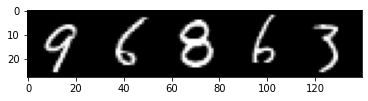


Test set: Average loss: 0.0382, Accuracy: 9883/10000 (99%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.145096
Train Epoch: 12 [640/60000 (1%)]	Loss: 0.157704
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.123883
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.126020
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.035636
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.135217
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.046106
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.067300
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.037969
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.043810
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.021626
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.038514
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.053366
Train Epoch: 12 [8320/60000 (14%)]	Loss: 0.302208
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.036641
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.120884
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.028830
Train Epoch: 12 [10880/60000 (18%)]	Loss: 0.131349
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.055806

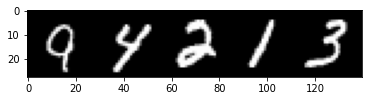


Test set: Average loss: 0.0378, Accuracy: 9882/10000 (99%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.078130
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.111765
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.056223
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.010392
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.059607
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.303502
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.124225
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.085923
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.009501
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.040200
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.016485
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.135104
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.110311
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.013943
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.091458
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.134743
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.059848
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.040952
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.020872

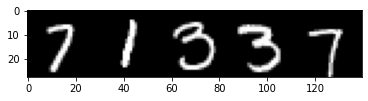


Test set: Average loss: 0.0377, Accuracy: 9881/10000 (99%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.031958
Train Epoch: 14 [640/60000 (1%)]	Loss: 0.068219
Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.022265
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.046603
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.011059
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.035773
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.081722
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.124423
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.096961
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.036654
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.080098
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.210630
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.024661
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.018442
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.091420
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.058510
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.181141
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.062763
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.101119

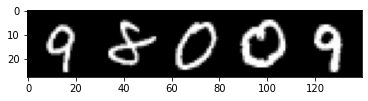


Test set: Average loss: 0.0378, Accuracy: 9881/10000 (99%)



In [ ]:
# Results using leaky_relu()
if __name__ == '__main__':
     main()

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307148
Train Epoch: 1 [640/60000 (1%)]	Loss: 1.537884
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.973338
Train Epoch: 1 [1920/60000 (3%)]	Loss: 0.776828
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.565256
Train Epoch: 1 [3200/60000 (5%)]	Loss: 0.480346
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.568668
Train Epoch: 1 [4480/60000 (7%)]	Loss: 0.211159
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.329888
Train Epoch: 1 [5760/60000 (10%)]	Loss: 0.385063
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.210548
Train Epoch: 1 [7040/60000 (12%)]	Loss: 0.294432
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.264652
Train Epoch: 1 [8320/60000 (14%)]	Loss: 0.286801
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.236101
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.390712
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.274750
Train Epoch: 1 [10880/60000 (18%)]	Loss: 0.156861
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.157358
Train Epoch: 1 [12160/60000 (20%)]	Loss: 0.566235
Train Epoch: 1 [12800/60000 (

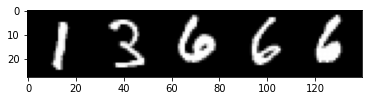


Test set: Average loss: 0.0542, Accuracy: 9827/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.096972
Train Epoch: 2 [640/60000 (1%)]	Loss: 0.049530
Train Epoch: 2 [1280/60000 (2%)]	Loss: 0.008056
Train Epoch: 2 [1920/60000 (3%)]	Loss: 0.114118
Train Epoch: 2 [2560/60000 (4%)]	Loss: 0.110675
Train Epoch: 2 [3200/60000 (5%)]	Loss: 0.148429
Train Epoch: 2 [3840/60000 (6%)]	Loss: 0.045584
Train Epoch: 2 [4480/60000 (7%)]	Loss: 0.025602
Train Epoch: 2 [5120/60000 (9%)]	Loss: 0.279274
Train Epoch: 2 [5760/60000 (10%)]	Loss: 0.138504
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.070799
Train Epoch: 2 [7040/60000 (12%)]	Loss: 0.088300
Train Epoch: 2 [7680/60000 (13%)]	Loss: 0.039967
Train Epoch: 2 [8320/60000 (14%)]	Loss: 0.076447
Train Epoch: 2 [8960/60000 (15%)]	Loss: 0.165541
Train Epoch: 2 [9600/60000 (16%)]	Loss: 0.235804
Train Epoch: 2 [10240/60000 (17%)]	Loss: 0.118389
Train Epoch: 2 [10880/60000 (18%)]	Loss: 0.054540
Train Epoch: 2 [11520/60000 (19%)]	Loss: 0.224946
Train Epoch: 2 [12

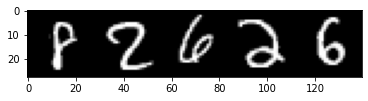


Test set: Average loss: 0.0383, Accuracy: 9866/10000 (99%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.047280
Train Epoch: 3 [640/60000 (1%)]	Loss: 0.067578
Train Epoch: 3 [1280/60000 (2%)]	Loss: 0.045750
Train Epoch: 3 [1920/60000 (3%)]	Loss: 0.016011
Train Epoch: 3 [2560/60000 (4%)]	Loss: 0.135912
Train Epoch: 3 [3200/60000 (5%)]	Loss: 0.103957
Train Epoch: 3 [3840/60000 (6%)]	Loss: 0.036861
Train Epoch: 3 [4480/60000 (7%)]	Loss: 0.067551
Train Epoch: 3 [5120/60000 (9%)]	Loss: 0.156248
Train Epoch: 3 [5760/60000 (10%)]	Loss: 0.078290
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.038168
Train Epoch: 3 [7040/60000 (12%)]	Loss: 0.081124
Train Epoch: 3 [7680/60000 (13%)]	Loss: 0.060302
Train Epoch: 3 [8320/60000 (14%)]	Loss: 0.080268
Train Epoch: 3 [8960/60000 (15%)]	Loss: 0.184896
Train Epoch: 3 [9600/60000 (16%)]	Loss: 0.046810
Train Epoch: 3 [10240/60000 (17%)]	Loss: 0.044947
Train Epoch: 3 [10880/60000 (18%)]	Loss: 0.014184
Train Epoch: 3 [11520/60000 (19%)]	Loss: 0.005328
Train Epoch: 3 [12

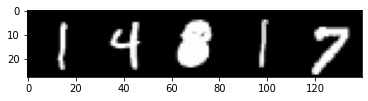


Test set: Average loss: 0.0416, Accuracy: 9875/10000 (99%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.095759
Train Epoch: 4 [640/60000 (1%)]	Loss: 0.148823
Train Epoch: 4 [1280/60000 (2%)]	Loss: 0.021511
Train Epoch: 4 [1920/60000 (3%)]	Loss: 0.031550
Train Epoch: 4 [2560/60000 (4%)]	Loss: 0.028364
Train Epoch: 4 [3200/60000 (5%)]	Loss: 0.032126
Train Epoch: 4 [3840/60000 (6%)]	Loss: 0.023013
Train Epoch: 4 [4480/60000 (7%)]	Loss: 0.100479
Train Epoch: 4 [5120/60000 (9%)]	Loss: 0.088817
Train Epoch: 4 [5760/60000 (10%)]	Loss: 0.087966
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.120416
Train Epoch: 4 [7040/60000 (12%)]	Loss: 0.097955
Train Epoch: 4 [7680/60000 (13%)]	Loss: 0.053771
Train Epoch: 4 [8320/60000 (14%)]	Loss: 0.093567
Train Epoch: 4 [8960/60000 (15%)]	Loss: 0.025512
Train Epoch: 4 [9600/60000 (16%)]	Loss: 0.008134
Train Epoch: 4 [10240/60000 (17%)]	Loss: 0.008875
Train Epoch: 4 [10880/60000 (18%)]	Loss: 0.033346
Train Epoch: 4 [11520/60000 (19%)]	Loss: 0.067813
Train Epoch: 4 [12

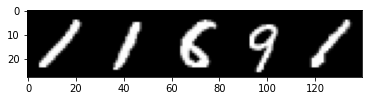


Test set: Average loss: 0.0325, Accuracy: 9896/10000 (99%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.012119
Train Epoch: 5 [640/60000 (1%)]	Loss: 0.011245
Train Epoch: 5 [1280/60000 (2%)]	Loss: 0.022011
Train Epoch: 5 [1920/60000 (3%)]	Loss: 0.070014
Train Epoch: 5 [2560/60000 (4%)]	Loss: 0.027342
Train Epoch: 5 [3200/60000 (5%)]	Loss: 0.087191
Train Epoch: 5 [3840/60000 (6%)]	Loss: 0.027733
Train Epoch: 5 [4480/60000 (7%)]	Loss: 0.094845
Train Epoch: 5 [5120/60000 (9%)]	Loss: 0.048218
Train Epoch: 5 [5760/60000 (10%)]	Loss: 0.038101
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.036990
Train Epoch: 5 [7040/60000 (12%)]	Loss: 0.091380
Train Epoch: 5 [7680/60000 (13%)]	Loss: 0.026868
Train Epoch: 5 [8320/60000 (14%)]	Loss: 0.116866
Train Epoch: 5 [8960/60000 (15%)]	Loss: 0.151585
Train Epoch: 5 [9600/60000 (16%)]	Loss: 0.028260
Train Epoch: 5 [10240/60000 (17%)]	Loss: 0.029279
Train Epoch: 5 [10880/60000 (18%)]	Loss: 0.047804
Train Epoch: 5 [11520/60000 (19%)]	Loss: 0.032921
Train Epoch: 5 [12

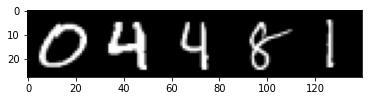


Test set: Average loss: 0.0332, Accuracy: 9894/10000 (99%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.027245
Train Epoch: 6 [640/60000 (1%)]	Loss: 0.008116
Train Epoch: 6 [1280/60000 (2%)]	Loss: 0.016603
Train Epoch: 6 [1920/60000 (3%)]	Loss: 0.138831
Train Epoch: 6 [2560/60000 (4%)]	Loss: 0.065123
Train Epoch: 6 [3200/60000 (5%)]	Loss: 0.007863
Train Epoch: 6 [3840/60000 (6%)]	Loss: 0.124801
Train Epoch: 6 [4480/60000 (7%)]	Loss: 0.004573
Train Epoch: 6 [5120/60000 (9%)]	Loss: 0.021469
Train Epoch: 6 [5760/60000 (10%)]	Loss: 0.070670
Train Epoch: 6 [6400/60000 (11%)]	Loss: 0.046742
Train Epoch: 6 [7040/60000 (12%)]	Loss: 0.117269
Train Epoch: 6 [7680/60000 (13%)]	Loss: 0.037904
Train Epoch: 6 [8320/60000 (14%)]	Loss: 0.161001
Train Epoch: 6 [8960/60000 (15%)]	Loss: 0.019480
Train Epoch: 6 [9600/60000 (16%)]	Loss: 0.059367
Train Epoch: 6 [10240/60000 (17%)]	Loss: 0.030190
Train Epoch: 6 [10880/60000 (18%)]	Loss: 0.080767
Train Epoch: 6 [11520/60000 (19%)]	Loss: 0.090095
Train Epoch: 6 [12

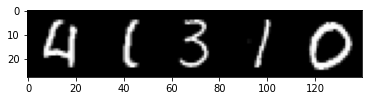


Test set: Average loss: 0.0289, Accuracy: 9905/10000 (99%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.222068
Train Epoch: 7 [640/60000 (1%)]	Loss: 0.069575
Train Epoch: 7 [1280/60000 (2%)]	Loss: 0.062628
Train Epoch: 7 [1920/60000 (3%)]	Loss: 0.047034
Train Epoch: 7 [2560/60000 (4%)]	Loss: 0.055722
Train Epoch: 7 [3200/60000 (5%)]	Loss: 0.021809
Train Epoch: 7 [3840/60000 (6%)]	Loss: 0.002744
Train Epoch: 7 [4480/60000 (7%)]	Loss: 0.002153
Train Epoch: 7 [5120/60000 (9%)]	Loss: 0.025150
Train Epoch: 7 [5760/60000 (10%)]	Loss: 0.072959
Train Epoch: 7 [6400/60000 (11%)]	Loss: 0.022443
Train Epoch: 7 [7040/60000 (12%)]	Loss: 0.189369
Train Epoch: 7 [7680/60000 (13%)]	Loss: 0.036211
Train Epoch: 7 [8320/60000 (14%)]	Loss: 0.123571
Train Epoch: 7 [8960/60000 (15%)]	Loss: 0.007236
Train Epoch: 7 [9600/60000 (16%)]	Loss: 0.011078
Train Epoch: 7 [10240/60000 (17%)]	Loss: 0.016541
Train Epoch: 7 [10880/60000 (18%)]	Loss: 0.178415
Train Epoch: 7 [11520/60000 (19%)]	Loss: 0.019691
Train Epoch: 7 [12

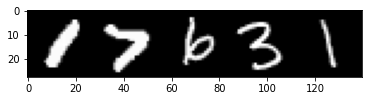


Test set: Average loss: 0.0297, Accuracy: 9898/10000 (99%)

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.010728
Train Epoch: 8 [640/60000 (1%)]	Loss: 0.117717
Train Epoch: 8 [1280/60000 (2%)]	Loss: 0.053034
Train Epoch: 8 [1920/60000 (3%)]	Loss: 0.151854
Train Epoch: 8 [2560/60000 (4%)]	Loss: 0.031439
Train Epoch: 8 [3200/60000 (5%)]	Loss: 0.017375
Train Epoch: 8 [3840/60000 (6%)]	Loss: 0.087299
Train Epoch: 8 [4480/60000 (7%)]	Loss: 0.008403
Train Epoch: 8 [5120/60000 (9%)]	Loss: 0.018423
Train Epoch: 8 [5760/60000 (10%)]	Loss: 0.029065
Train Epoch: 8 [6400/60000 (11%)]	Loss: 0.045012
Train Epoch: 8 [7040/60000 (12%)]	Loss: 0.034104
Train Epoch: 8 [7680/60000 (13%)]	Loss: 0.098642
Train Epoch: 8 [8320/60000 (14%)]	Loss: 0.096749
Train Epoch: 8 [8960/60000 (15%)]	Loss: 0.045626
Train Epoch: 8 [9600/60000 (16%)]	Loss: 0.002315
Train Epoch: 8 [10240/60000 (17%)]	Loss: 0.113743
Train Epoch: 8 [10880/60000 (18%)]	Loss: 0.036972
Train Epoch: 8 [11520/60000 (19%)]	Loss: 0.022802
Train Epoch: 8 [12

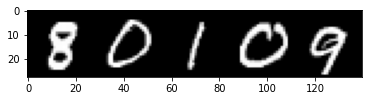


Test set: Average loss: 0.0284, Accuracy: 9908/10000 (99%)

Train Epoch: 9 [0/60000 (0%)]	Loss: 0.069090
Train Epoch: 9 [640/60000 (1%)]	Loss: 0.020414
Train Epoch: 9 [1280/60000 (2%)]	Loss: 0.047032
Train Epoch: 9 [1920/60000 (3%)]	Loss: 0.026303
Train Epoch: 9 [2560/60000 (4%)]	Loss: 0.021911
Train Epoch: 9 [3200/60000 (5%)]	Loss: 0.050465
Train Epoch: 9 [3840/60000 (6%)]	Loss: 0.027103
Train Epoch: 9 [4480/60000 (7%)]	Loss: 0.012221
Train Epoch: 9 [5120/60000 (9%)]	Loss: 0.055728
Train Epoch: 9 [5760/60000 (10%)]	Loss: 0.031876
Train Epoch: 9 [6400/60000 (11%)]	Loss: 0.066684
Train Epoch: 9 [7040/60000 (12%)]	Loss: 0.035696
Train Epoch: 9 [7680/60000 (13%)]	Loss: 0.042333
Train Epoch: 9 [8320/60000 (14%)]	Loss: 0.107361
Train Epoch: 9 [8960/60000 (15%)]	Loss: 0.011922
Train Epoch: 9 [9600/60000 (16%)]	Loss: 0.105331
Train Epoch: 9 [10240/60000 (17%)]	Loss: 0.010797
Train Epoch: 9 [10880/60000 (18%)]	Loss: 0.027499
Train Epoch: 9 [11520/60000 (19%)]	Loss: 0.041061
Train Epoch: 9 [12

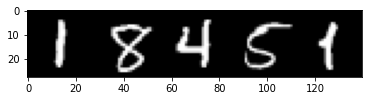


Test set: Average loss: 0.0291, Accuracy: 9910/10000 (99%)

Train Epoch: 10 [0/60000 (0%)]	Loss: 0.088433
Train Epoch: 10 [640/60000 (1%)]	Loss: 0.012336
Train Epoch: 10 [1280/60000 (2%)]	Loss: 0.018362
Train Epoch: 10 [1920/60000 (3%)]	Loss: 0.011486
Train Epoch: 10 [2560/60000 (4%)]	Loss: 0.006817
Train Epoch: 10 [3200/60000 (5%)]	Loss: 0.118964
Train Epoch: 10 [3840/60000 (6%)]	Loss: 0.003593
Train Epoch: 10 [4480/60000 (7%)]	Loss: 0.017245
Train Epoch: 10 [5120/60000 (9%)]	Loss: 0.067740
Train Epoch: 10 [5760/60000 (10%)]	Loss: 0.028518
Train Epoch: 10 [6400/60000 (11%)]	Loss: 0.116998
Train Epoch: 10 [7040/60000 (12%)]	Loss: 0.089661
Train Epoch: 10 [7680/60000 (13%)]	Loss: 0.007657
Train Epoch: 10 [8320/60000 (14%)]	Loss: 0.017210
Train Epoch: 10 [8960/60000 (15%)]	Loss: 0.038149
Train Epoch: 10 [9600/60000 (16%)]	Loss: 0.015070
Train Epoch: 10 [10240/60000 (17%)]	Loss: 0.123733
Train Epoch: 10 [10880/60000 (18%)]	Loss: 0.065915
Train Epoch: 10 [11520/60000 (19%)]	Loss: 0.066890

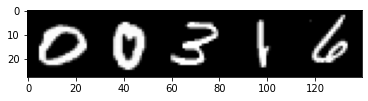


Test set: Average loss: 0.0281, Accuracy: 9906/10000 (99%)

Train Epoch: 11 [0/60000 (0%)]	Loss: 0.054358
Train Epoch: 11 [640/60000 (1%)]	Loss: 0.058691
Train Epoch: 11 [1280/60000 (2%)]	Loss: 0.015669
Train Epoch: 11 [1920/60000 (3%)]	Loss: 0.052010
Train Epoch: 11 [2560/60000 (4%)]	Loss: 0.017466
Train Epoch: 11 [3200/60000 (5%)]	Loss: 0.046277
Train Epoch: 11 [3840/60000 (6%)]	Loss: 0.138167
Train Epoch: 11 [4480/60000 (7%)]	Loss: 0.018998
Train Epoch: 11 [5120/60000 (9%)]	Loss: 0.077983
Train Epoch: 11 [5760/60000 (10%)]	Loss: 0.037361
Train Epoch: 11 [6400/60000 (11%)]	Loss: 0.035081
Train Epoch: 11 [7040/60000 (12%)]	Loss: 0.014960
Train Epoch: 11 [7680/60000 (13%)]	Loss: 0.056287
Train Epoch: 11 [8320/60000 (14%)]	Loss: 0.021544
Train Epoch: 11 [8960/60000 (15%)]	Loss: 0.015757
Train Epoch: 11 [9600/60000 (16%)]	Loss: 0.032407
Train Epoch: 11 [10240/60000 (17%)]	Loss: 0.011343
Train Epoch: 11 [10880/60000 (18%)]	Loss: 0.048674
Train Epoch: 11 [11520/60000 (19%)]	Loss: 0.015303

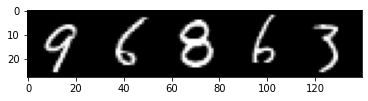


Test set: Average loss: 0.0282, Accuracy: 9906/10000 (99%)

Train Epoch: 12 [0/60000 (0%)]	Loss: 0.051275
Train Epoch: 12 [640/60000 (1%)]	Loss: 0.050956
Train Epoch: 12 [1280/60000 (2%)]	Loss: 0.019489
Train Epoch: 12 [1920/60000 (3%)]	Loss: 0.069961
Train Epoch: 12 [2560/60000 (4%)]	Loss: 0.014729
Train Epoch: 12 [3200/60000 (5%)]	Loss: 0.062373
Train Epoch: 12 [3840/60000 (6%)]	Loss: 0.012894
Train Epoch: 12 [4480/60000 (7%)]	Loss: 0.016034
Train Epoch: 12 [5120/60000 (9%)]	Loss: 0.021867
Train Epoch: 12 [5760/60000 (10%)]	Loss: 0.074232
Train Epoch: 12 [6400/60000 (11%)]	Loss: 0.003632
Train Epoch: 12 [7040/60000 (12%)]	Loss: 0.020941
Train Epoch: 12 [7680/60000 (13%)]	Loss: 0.016247
Train Epoch: 12 [8320/60000 (14%)]	Loss: 0.161599
Train Epoch: 12 [8960/60000 (15%)]	Loss: 0.022760
Train Epoch: 12 [9600/60000 (16%)]	Loss: 0.026186
Train Epoch: 12 [10240/60000 (17%)]	Loss: 0.009564
Train Epoch: 12 [10880/60000 (18%)]	Loss: 0.081384
Train Epoch: 12 [11520/60000 (19%)]	Loss: 0.038860

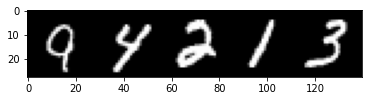


Test set: Average loss: 0.0279, Accuracy: 9910/10000 (99%)

Train Epoch: 13 [0/60000 (0%)]	Loss: 0.008313
Train Epoch: 13 [640/60000 (1%)]	Loss: 0.041577
Train Epoch: 13 [1280/60000 (2%)]	Loss: 0.024253
Train Epoch: 13 [1920/60000 (3%)]	Loss: 0.021783
Train Epoch: 13 [2560/60000 (4%)]	Loss: 0.028508
Train Epoch: 13 [3200/60000 (5%)]	Loss: 0.262244
Train Epoch: 13 [3840/60000 (6%)]	Loss: 0.017335
Train Epoch: 13 [4480/60000 (7%)]	Loss: 0.100357
Train Epoch: 13 [5120/60000 (9%)]	Loss: 0.014826
Train Epoch: 13 [5760/60000 (10%)]	Loss: 0.006392
Train Epoch: 13 [6400/60000 (11%)]	Loss: 0.005553
Train Epoch: 13 [7040/60000 (12%)]	Loss: 0.058171
Train Epoch: 13 [7680/60000 (13%)]	Loss: 0.083802
Train Epoch: 13 [8320/60000 (14%)]	Loss: 0.047403
Train Epoch: 13 [8960/60000 (15%)]	Loss: 0.011002
Train Epoch: 13 [9600/60000 (16%)]	Loss: 0.084035
Train Epoch: 13 [10240/60000 (17%)]	Loss: 0.019438
Train Epoch: 13 [10880/60000 (18%)]	Loss: 0.015691
Train Epoch: 13 [11520/60000 (19%)]	Loss: 0.013044

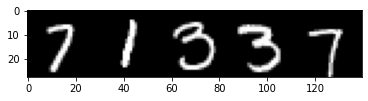


Test set: Average loss: 0.0278, Accuracy: 9904/10000 (99%)

Train Epoch: 14 [0/60000 (0%)]	Loss: 0.027102
Train Epoch: 14 [640/60000 (1%)]	Loss: 0.024839
Train Epoch: 14 [1280/60000 (2%)]	Loss: 0.012252
Train Epoch: 14 [1920/60000 (3%)]	Loss: 0.024534
Train Epoch: 14 [2560/60000 (4%)]	Loss: 0.003225
Train Epoch: 14 [3200/60000 (5%)]	Loss: 0.007044
Train Epoch: 14 [3840/60000 (6%)]	Loss: 0.067787
Train Epoch: 14 [4480/60000 (7%)]	Loss: 0.031026
Train Epoch: 14 [5120/60000 (9%)]	Loss: 0.072609
Train Epoch: 14 [5760/60000 (10%)]	Loss: 0.013569
Train Epoch: 14 [6400/60000 (11%)]	Loss: 0.011626
Train Epoch: 14 [7040/60000 (12%)]	Loss: 0.159529
Train Epoch: 14 [7680/60000 (13%)]	Loss: 0.037287
Train Epoch: 14 [8320/60000 (14%)]	Loss: 0.033226
Train Epoch: 14 [8960/60000 (15%)]	Loss: 0.053039
Train Epoch: 14 [9600/60000 (16%)]	Loss: 0.029782
Train Epoch: 14 [10240/60000 (17%)]	Loss: 0.090918
Train Epoch: 14 [10880/60000 (18%)]	Loss: 0.016376
Train Epoch: 14 [11520/60000 (19%)]	Loss: 0.049293

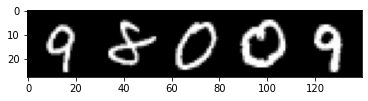


Test set: Average loss: 0.0279, Accuracy: 9904/10000 (99%)



In [ ]:
# Results using hardswish()
if __name__ == '__main__':
     main()